In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util import *
from synth_spec import *

First, get observed spectrum and flatten.

In [2]:
KPF_file = "../../KP.20240619.75381.18_L1.fits"
wave, flux = get_spectrum(KPF_file, 2, "GREEN")

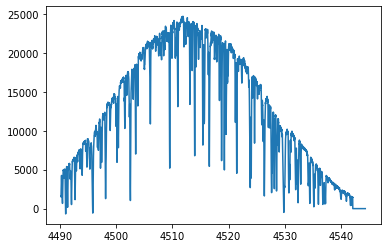

In [3]:
my_wave = wave[1]
my_flux = flux[1]

plt.plot(my_wave, my_flux)
plt.show()

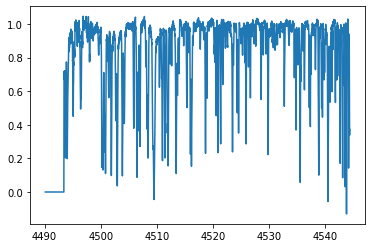

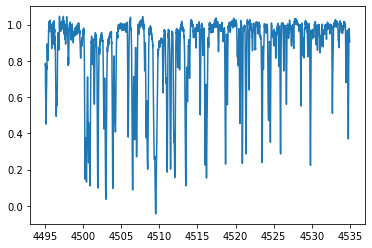

In [4]:
flat_flux, yfit = flatspec_spline(my_wave, my_flux, np.ones(len(my_wave)))

plt.plot(my_wave, flat_flux)
plt.show()

mask = (my_wave > 4495) & (my_wave < 4535)

plt.plot(my_wave[mask], flat_flux[mask])
plt.show()

Get synthetic spectrum.

In [5]:
filename = "synth_spec.hdf5"
Teff_target = 5800
Z_target = 0

download_stellar_model_grid(filename, Teff_target, Z_target)

lte05800-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits: 100%|█████████████████████████████████████████████| 72/72 [00:00<00:00, 798.09it/s]
Processing [5.8e+03 5.0e+00 0.0e+00]: 100%|██████████████████████████████████████████████████████████████████| 72/72 [00:58<00:00,  1.22it/s]


keeping grid as is


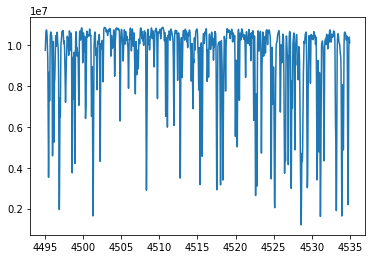

In [6]:
synth_wave, synth_flux = get_synth_spectrum(filename, 5700, 4.5, 0)

synth_mask = (synth_wave > 4495) & (synth_wave < 4535)

plt.plot(synth_wave[synth_mask], synth_flux[synth_mask])
plt.show()

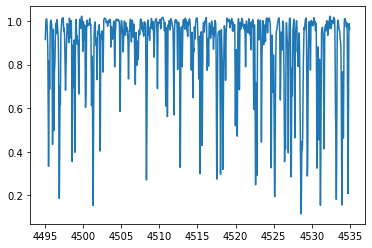

In [7]:
flat_synth_flux, yfit = flatspec_spline(synth_wave[synth_mask], synth_flux[synth_mask], np.ones(len(synth_wave[synth_mask])))

plt.plot(synth_wave[synth_mask], flat_synth_flux)
plt.show()

Combine the observed and synthetic spectrum.

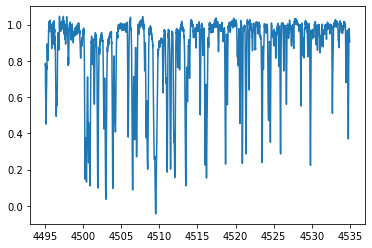

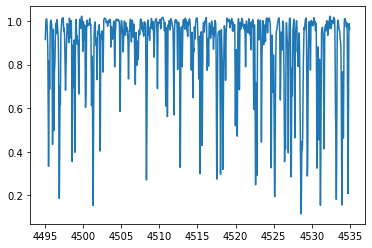

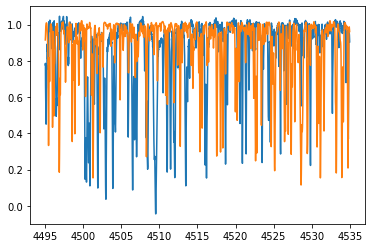

In [8]:
plt.plot(my_wave[mask], flat_flux[mask])
plt.show()

plt.plot(synth_wave[synth_mask], flat_synth_flux)
plt.show()

plt.plot(my_wave[mask], flat_flux[mask])
plt.plot(synth_wave[synth_mask], flat_synth_flux)
plt.show()

RV shift (in km/s) = 0


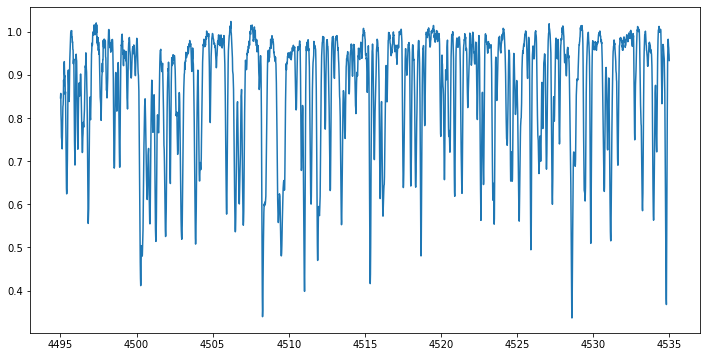

RV shift (in km/s) = 20


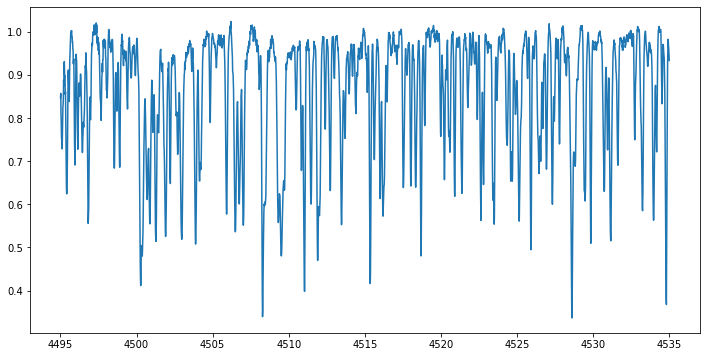

RV shift (in km/s) = 40


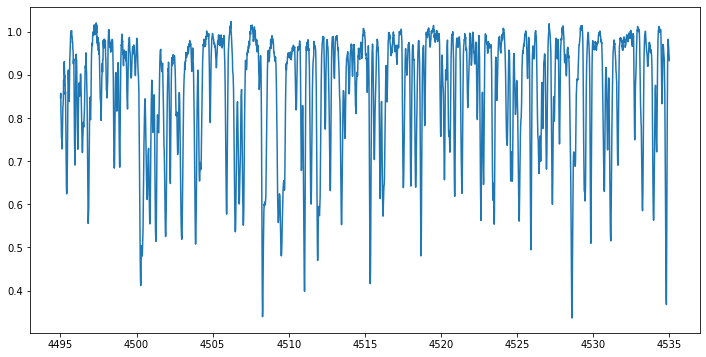

RV shift (in km/s) = 60


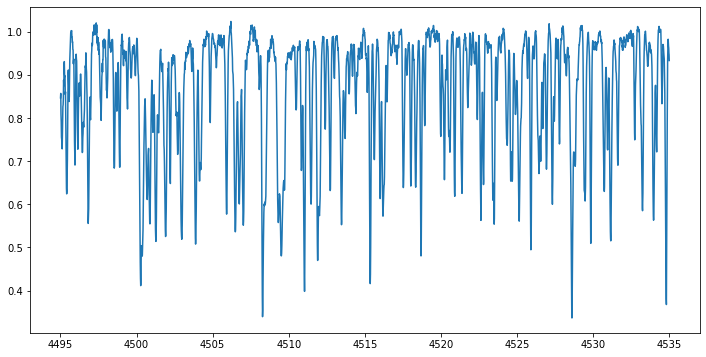

RV shift (in km/s) = 80


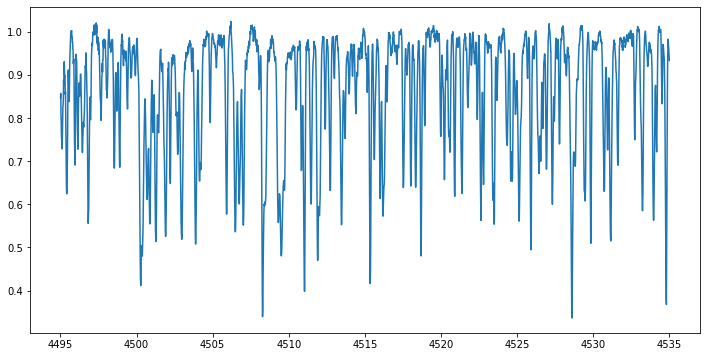

RV shift (in km/s) = 100


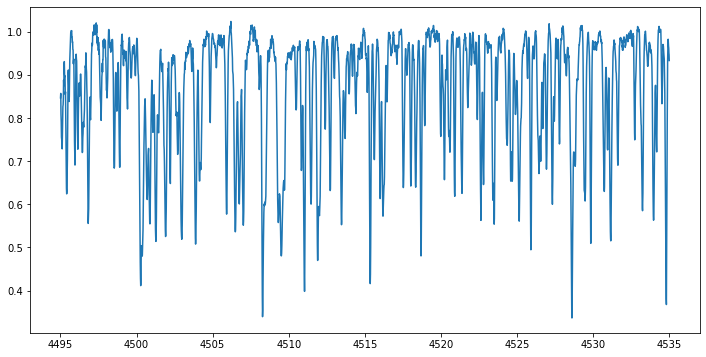

RV shift (in km/s) = 120


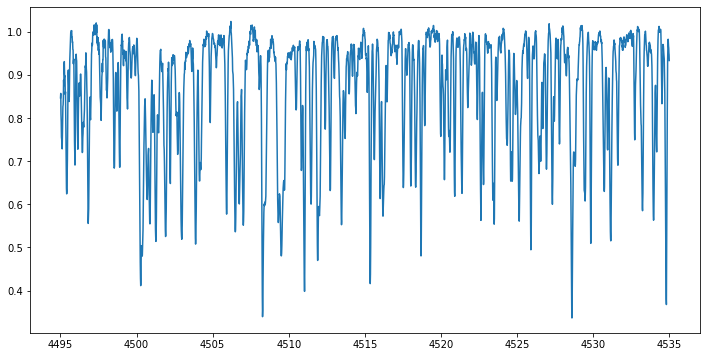

RV shift (in km/s) = 140


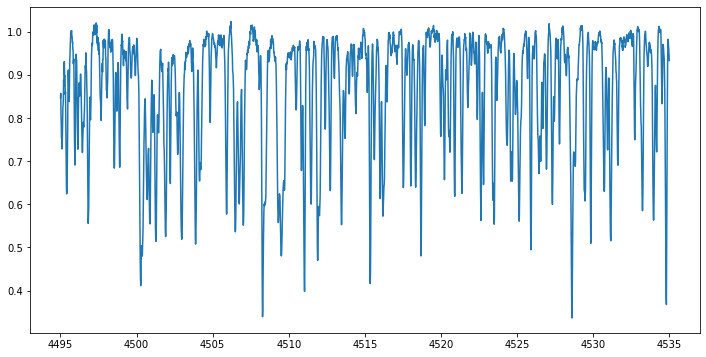

RV shift (in km/s) = 160


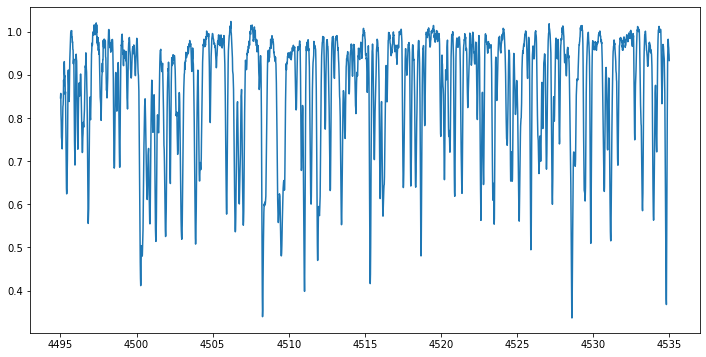

RV shift (in km/s) = 180


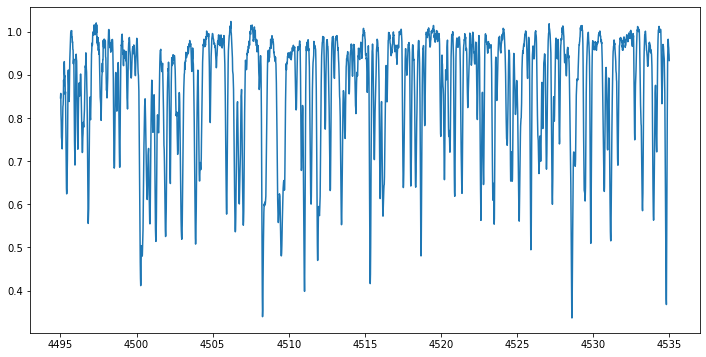

In [12]:
for rv_shift in np.arange(0,200,20):
    print("RV shift (in km/s) =", rv_shift)

    combined_wave, combined_flux = combine_spectra(synth_wave[synth_mask], flat_synth_flux, my_wave[mask], flat_flux[mask], rv=rv_shift)

    plt.figure(figsize=(12,6))
    plt.plot(combined_wave, combined_flux)
    plt.show()

In [26]:
combined_wave1, combined_flux1 = combine_spectra(synth_wave[synth_mask], flat_synth_flux, my_wave[mask], flat_flux[mask], rv=1000)
combined_wave2, combined_flux2 = combine_spectra(synth_wave[synth_mask], flat_synth_flux, my_wave[mask], flat_flux[mask], rv=0)


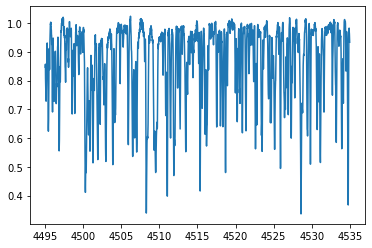

In [27]:
plt.plot(combined_wave1, combined_flux1)

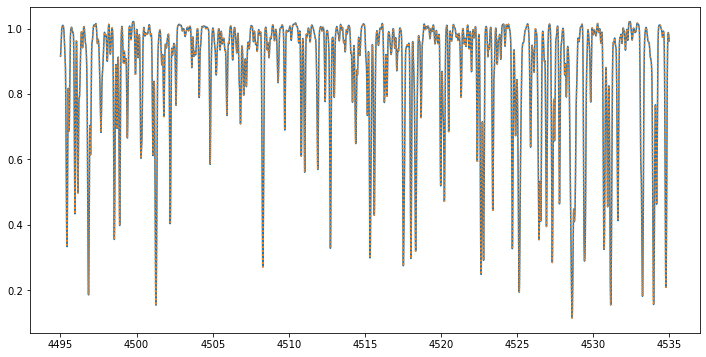

In [39]:
plt.figure(figsize=(12,6))

new_wave_synth1 = synth_wave[synth_mask] * (1 + (0/3e8/1000))

plt.plot(new_wave_synth1, flat_synth_flux)

new_wave_synth2 = synth_wave[synth_mask] * (1 + (100000/3e8/1000))

plt.plot(new_wave_synth2, flat_synth_flux, ls=":")

In [40]:
new_wave_synth1

array([4495.00152616, 4495.01312021, 4495.02471428, ..., 4534.96887187,
       4534.980569  , 4534.99226616])

In [41]:
new_wave_synth2

array([4495.0030245 , 4495.01461854, 4495.02621262, ..., 4534.97038352,
       4534.98208066, 4534.99377783])